<a href="https://colab.research.google.com/github/omgits0mar/CAPTCHA-verifier/blob/main/Fine-tune_Microsoft_TrOCR_on_Captcha_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tune TrOCR on the IAM Handwriting Database and the CAPTCHA recognition Dataset

In this notebook, we are going to fine-tune a pre-trained TrOCR model on the [IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database) a collection of annotated images of handwritten text, and the [CAPTCHA dataset](https://www.kaggle.com/datasets/parsasam/captcha-dataset) from kaggle a collection contains more than 113,000 colorful 5-character images.

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text.

This figure gives a good overview of the model (from the original paper):

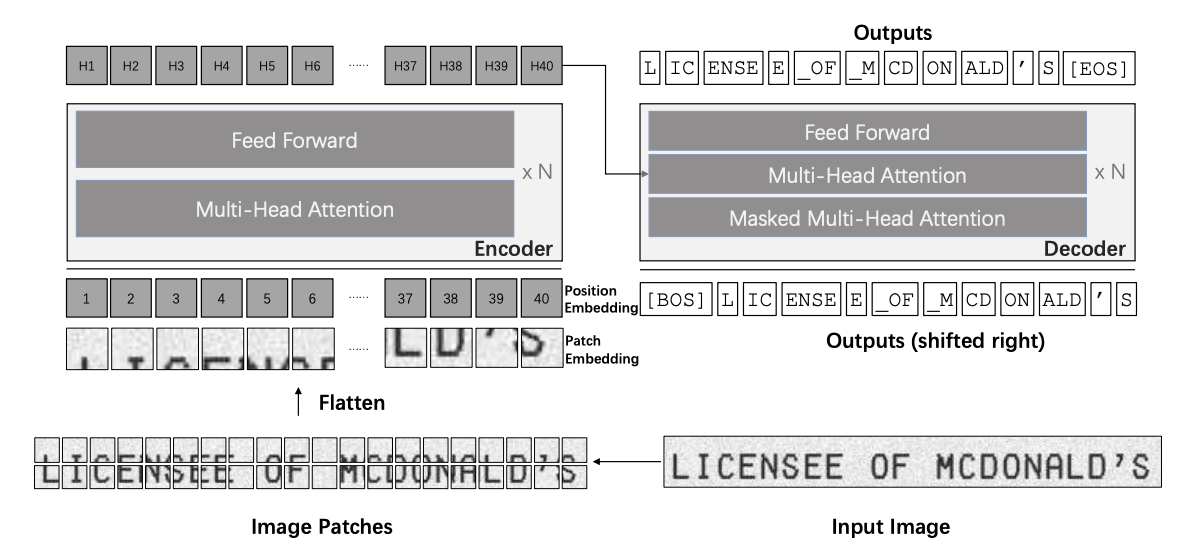

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook.

We will fine-tune the model using native PyTorch.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

We will not be using HuggingFace Datasets in this notebook for data preprocessing, we will just create a good old basic PyTorch Dataset.

In [ ]:
!nvidia-smi

Fri Aug 18 07:40:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr).

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

In [ ]:
!wget https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip && unzip -q captcha_images_v2.zip

--2023-08-18 07:41:06--  https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip [following]
--2023-08-18 07:41:06--  https://raw.githubusercontent.com/AakashKumarNain/CaptchaCracker/master/captcha_images_v2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9075967 (8.7M) [application/zip]
Saving to: ‘captcha_images_v2.zip.1’

captcha_images_v2.z 100%[===================>]   8.66M  --.-KB/s    in 0.07s   

2023-08-18 07:41:06 (125 MB/s) - ‘captcha_images_v2.zip

In [ ]:
!mkdir -p IAM && mv captcha_images_v2 IAM/image

In [ ]:
!cd IAM/image && for fname in `ls *.png`; do echo -e "$fname\t${fname:0:5}" >> ../gt_test.txt; done

ls: cannot access '*.png': No such file or directory


In [ ]:
import pandas as pd

df = pd.read_fwf('IAM/gt_test.txt', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df

,file_name,text
0,226md.png,226md
1,22d5n.png,22d5n
2,2356g.png,2356g
3,23mdg.png,23mdg
4,23n88.png,23n88
...,...,...
1035,yx2d4.png,yx2d4
1036,yxd7m.png,yxd7m
1037,yy824.png,yy824
1038,yyg5g.png,yyg5g


__________________________________________________________________________
# 1ST Part ☝ Training on only a small dataset (IAM Dataset) to test the model performance
___________________________________________________________________________

We split up the data into training + testing, using sklearn's `train_test_split` function.

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

Let's initialize the training and evaluation datasets:

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.6 MB/s eta 0:00:00


In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
train_dataset = IAMDataset(root_dir='IAM/image/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='IAM/image/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 832
Number of validation examples: 208


Let's verify an example from the training dataset:

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


We can also check the original image and decode the labels:

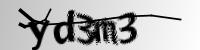

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

yd3m3


Let's create corresponding dataloaders:

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=24, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=24)

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")
model.to(device)

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
!pip install --upgrade datasets

In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00


We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-21-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(5):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   total_cer = valid_cer / len(eval_dataloader)
   print("Validation CER:", total_cer)
   if total_cer < 0.01:
     import datetime
     save_pretrained_dir = f'drive/MyDrive/{total_cer}_{epoch}_{datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9),"JST")).strftime("%Y%m%dT%H%M%S")}'
     model.save_pretrained(save_pretrained_dir)

model.save_pretrained("My_model")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/35 [00:00<?, ?it/s]

Loss after epoch 0: 2.9929639867373874


  0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Validation CER: 0.07175925925925926


  0%|          | 0/35 [00:00<?, ?it/s]

Loss after epoch 1: 0.7295417283262525


  0%|          | 0/9 [00:00<?, ?it/s]

Validation CER: 0.053240740740740734


  0%|          | 0/35 [00:00<?, ?it/s]

Loss after epoch 2: 0.48726818050657


  0%|          | 0/9 [00:00<?, ?it/s]

Validation CER: 0.033796296296296297


  0%|          | 0/35 [00:00<?, ?it/s]

Loss after epoch 3: 0.4070039212703705


  0%|          | 0/9 [00:00<?, ?it/s]

Validation CER: 0.03888888888888889


  0%|          | 0/35 [00:00<?, ?it/s]

Loss after epoch 4: 0.3544022287641253


  0%|          | 0/9 [00:00<?, ?it/s]

Validation CER: 0.02962962962962963


## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

For inference on new images, I refer to my inference notebook, that can also be found in my [Transformers Tutorials repository](https://github.com/NielsRogge/Transformers-Tutorials) on Github.

In [ ]:
from IPython.display import display

model2 = VisionEncoderDecoderModel.from_pretrained("/content/My_model")
for file_name in test_df['file_name']:
  image = Image.open(train_dataset.root_dir + file_name).convert("RGB")
  display(image)

  generated_ids = model2.generate(processor(image, return_tensors="pt").pixel_values)
  print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

In [ ]:
import shutil

source_folder = "/content/My_model"
destination_folder = "/content/drive/MyDrive/My Projects/CAPTCHA Recognition"

shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/My Projects/CAPTCHA Recognition/My_model'

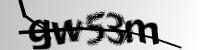

Predicted Text: gw53m


In [ ]:
# Image path
image_path = "/content/gw53m.png"

# Load and convert the image to grayscale
image_gray = Image.open(image_path).convert("L")  # Convert to grayscale
image_rgb = image_gray.convert("RGB")  # Convert back to RGB
display(image_rgb)

# Generate predicted text using the model
generated_ids = model2.generate(processor(image_rgb, return_tensors="pt").pixel_values)
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted Text:", predicted_text)

## Here you can see that the model could not generalize on different fomrates, Therfor we go to part 2 ⏬

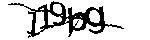

Predicted Text: gb4pg9


In [ ]:
import numpy as np

# Image path
image_path = "/content/119bg.jpg"

# Load and convert the image to grayscale with black text and gray background
image = Image.open(image_path).convert("L")  # Convert to grayscale
image = image.point(lambda p: 255 if p < 128 else 0)  # Convert text to black, background to white

# Convert the image to PNG format
png_image_path = image_path.replace(".jpg", ".png")
image.save(png_image_path)

# Resize and reshape the image to 3 dimensions
image_rgb = image.convert("RGB")# Resize and convert to RGB
display(image_rgb)
# image_rgb_array = np.array(image_rgb)
# image_3d = image_rgb_array[:, :, np.newaxis].repeat(3, axis=2)  # Reshape to 3 dimensions

# Generate predicted text using the model
generated_ids = model2.generate(processor(image_rgb, return_tensors="pt").pixel_values)
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted Text:", predicted_text)


_______________________________________________________________________________
# 2ND Part ✌ after the model performed well on small data, we Inlarge the dataset for more generalization accuracy by collecting images from other datasets and combine them together (IAM & CAPTCHA), then retrain the model.
________________________________________________________________________________

In [ ]:
!pip install kaggle

## Load the Json file of the CAPTCHA data on kaggle api
[link for the CAPTCHA data](https://www.kaggle.com/datasets/parsasam/captcha-dataset)

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


## Load the larger dataset of CAPTCHA from Kaggle API
[Dataset link](https://www.kaggle.com/datasets/parsasam/captcha-dataset?select=11Cbx.jpg)

In [ ]:
# Replace 'dataset-name' with the name of the dataset you want to download
!kaggle datasets download -d parsasam/captcha-dataset
# Unzip the downloaded file(s)
import zipfile
with zipfile.ZipFile('/content/captcha-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('Captcha Dataset V2')


captcha-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
import pandas as pd

# Define the path to the directory containing the images
image_folder = "/content/Captcha Dataset V2"

# Initialize empty lists to store filenames and labels
file_names = []
labels = []

# Loop through the image files in the folder
for file_name in os.listdir(image_folder):
    if file_name.endswith('.jpg'):
        # Extract the label from the file name (without the extension)
        label = os.path.splitext(file_name)[0]
        file_names.append(file_name)
        labels.append(label)

# Create a DataFrame with the collected data
data = {'file_name': file_names, 'text': labels}
df2 = pd.DataFrame(data)

# Display the DataFrame
df2

,file_name,text
0,yH8ut.jpg,yH8ut
1,YDHeA.jpg,YDHeA
2,WIWRt.jpg,WIWRt
3,wzwmF.jpg,wzwmF
4,XywXj.jpg,XywXj
...,...,...
113057,TC8BL.jpg,TC8BL
113058,qMxPL.jpg,qMxPL
113059,leeL3.jpg,leeL3
113060,JvnwX.jpg,JvnwX


## Here we prepare a larger dataset by combining both together ("IAM" and "Captcha") from git and kaggle into one folder and one csv containing their name and label

In [ ]:
# Concatenate the DataFrames
combined_df = pd.concat([df, df2], ignore_index=True)

# Shuffle the combined DataFrame
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the shuffled combined DataFrame to a CSV file
output_csv = "shuffled_combined_dataset.csv"
combined_df.to_csv(output_csv, index=False)

print("Shuffled combined DataFrame saved to:", output_csv)

Shuffled combined DataFrame saved to: shuffled_combined_dataset.csv


In [ ]:
combined_df.tail()

,file_name,text
114097,AxzDs.jpg,AxzDs
114098,bhNVs.jpg,bhNVs
114099,8vDld.jpg,8vDld
114100,pdw38.png,pdw38
114101,rreWP.jpg,rreWP


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(combined_df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

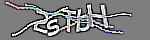

In [ ]:
from PIL import Image

image_path = "/content/Captcha Dataset V2/2sTbH.jpg"
image = Image.open(image_path)
display(image)


## move IAM images to the same folder of the second dataset to combine the images

In [ ]:
import shutil

source_folder = "/content/IAM/image"
destination_folder = "/content/Captcha Dataset V2"

# Loop through the image files in the source folder
for file_name in os.listdir(source_folder):
    if file_name.endswith('.png'):
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)

        # Move the image
        shutil.move(source_path, destination_path)

print("Images moved successfully.")


Images moved successfully.


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

## Prepare the train / test data

In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed")
train_dataset = IAMDataset(root_dir='/content/Captcha Dataset V2/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='/content/Captcha Dataset V2/',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 91281
Number of validation examples: 22821


In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


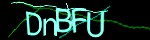

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

DnBFU


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)

## Loading the model again

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-printed")
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
!pip install --upgrade datasets
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

<ipython-input-29-c81d87c6f9c2>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [ ]:
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

## Model Training

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(1):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader, desc=f"Epoch {epoch} Training"):
      # get the inputs
      for k, v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss / len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader, desc=f"Epoch {epoch} Evaluation"):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   total_cer = valid_cer / len(eval_dataloader)
   print("Validation CER:", total_cer)
   if total_cer < 0.01:
     import datetime
     save_pretrained_dir = f'drive/MyDrive/{total_cer}_{epoch}_{datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9),"JST")).strftime("%Y%m%dT%H%M%S")}'
     model.save_pretrained(save_pretrained_dir)

model.save_pretrained("My_model_large")


Epoch 0 Training:   0%|          | 0/5706 [00:00<?, ?it/s]

Loss after epoch 0: 0.5332889751923886


Epoch 0 Evaluation:   0%|          | 0/5706 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Validation CER: 0.13595338240448585


In [ ]:
import shutil

source_folder = "/content/My_model_largev11"
destination_folder = "/content/drive/MyDrive/My Projects/CAPTCHA Recognition"

shutil.move(source_folder, destination_folder)


'/content/drive/MyDrive/My Projects/CAPTCHA Recognition/My_model_largev11'

## Model Evaluation and Testing

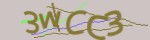

3wCC3


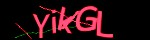

YikGL


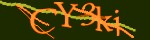

CY3ki


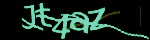

Jt4az


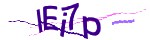

IEi7p


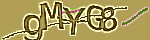

gMYQ8


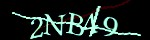

2NB49


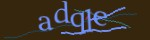

adqle


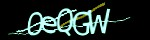

OeQGW


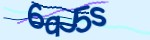

6qJ5s


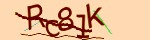

Rc81k


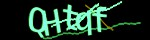

QHtqf


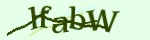

lfabW


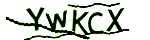

YwKCX


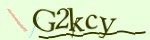

G2kcy


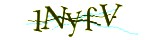

1NyfV


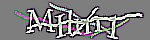

MtLrU


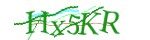

Hx5KR


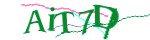

Air7D


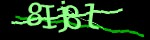

8Ij8l


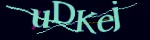

uDKej


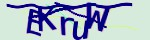

EKruW


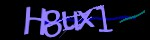

H8ux1


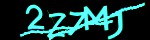

2z7Mj


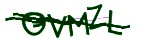

gvMzL


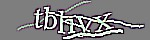

tbhvx


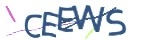

CEEWS


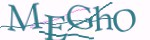

MEGhO


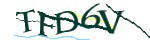

TfD6V


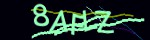

8ATLZ


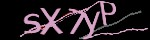

sX7yP


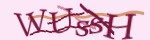

WUssH


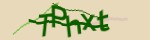

TPhxt


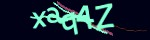

xaq4Z


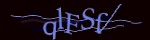

qlFSf


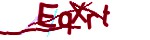

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import display

model2 = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/My Projects/CAPTCHA Recognition/My_model_largev11")
for file_name in test_df['file_name']:
  image = Image.open(train_dataset.root_dir + file_name).convert("RGB")
  display(image)

  generated_ids = model2.generate(processor(image, return_tensors="pt").pixel_values)
  print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0])

_______________________________________________________________________________
## Conclusion here you can see that it has become way more better and way more general to any image than before.
________________________________________________________________________________

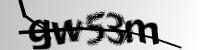

Predicted Text: gwS3m


In [ ]:
# Image path
image_path = "/content/gw53m.png"

# Load and convert the image to grayscale
image_gray = Image.open(image_path).convert("L")  # Convert to grayscale
image_rgb = image_gray.convert("RGB")  # Convert back to RGB
display(image_rgb)

# Generate predicted text using the model
generated_ids = model2.generate(processor(image_rgb, return_tensors="pt").pixel_values)
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted Text:", predicted_text)

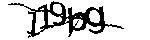

Predicted Text: l19bg


In [ ]:
import numpy as np

# Image path
image_path = "/content/119bg.jpg"

# Load and convert the image to grayscale with black text and gray background
image_raw = Image.open(image_path)
image = Image.open(image_path).convert("L")  # Convert to grayscale
image = image.point(lambda p: 255 if p < 128 else 0)  # Convert text to black, background to white

# Convert the image to PNG format
png_image_path = image_path.replace(".jpg", ".png")
image.save(png_image_path)

# Resize and reshape the image to 3 dimensions
image_rgb = image.convert("RGB")# Resize and convert to RGB
display(image_rgb)
# image_rgb_array = np.array(image_rgb)
# image_3d = image_rgb_array[:, :, np.newaxis].repeat(3, axis=2)  # Reshape to 3 dimensions

# Generate predicted text using the model
generated_ids = model2.generate(processor(image_rgb, return_tensors="pt").pixel_values)
predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted Text:", predicted_text)


## This code snippt is to continue training from the last epoch later on to farther increase the accuracy score of the model

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

# Optimizer setup
optimizer = AdamW(model.parameters(), lr=5e-5)

# Load the saved checkpoint
saved_checkpoint = "/content/drive/MyDrive/My Projects/CAPTCHA Recognition/My_model_large"
model = VisionEncoderDecoderModel.from_pretrained(saved_checkpoint)
model.to(device)

# Continue training from the saved checkpoint
for epoch in range(1, 3):  # Start from epoch 1 (change as needed)
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader, desc=f"Epoch {epoch} Training"):
      # get the inputs
      for k, v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss / len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader, desc=f"Epoch {epoch} Evaluation"):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   total_cer = valid_cer / len(eval_dataloader)
   print("Validation CER:", total_cer)
   if total_cer < 0.01:
     import datetime
     save_pretrained_dir = f'drive/MyDrive/{total_cer}_{epoch}_{datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9),"JST")).strftime("%Y%m%dT%H%M%S")}'
     model.save_pretrained(save_pretrained_dir)

# Save the model after training
model.save_pretrained("My_model_largev11")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Training:   0%|          | 0/5706 [00:00<?, ?it/s]

Loss after epoch 1: 0.3281747958751162


Epoch 1 Evaluation:   0%|          | 0/5706 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Validation CER: 0.12607781282860106


Epoch 2 Training:   0%|          | 0/5706 [00:00<?, ?it/s]

Loss after epoch 2: 0.3282976456083125


Epoch 2 Evaluation:   0%|          | 0/5706 [00:00<?, ?it/s]

Validation CER: 0.12607781282860106


<div align="center">
  
# End of Notebook, Thank you! 😊
for any questions or for more information, please contact 0mar.khaled29@gmail.com

</div>
